<h1>IMDB Reviews Sentiment Analysis</h1>

<h2>Review the Data</h2>
<hr>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import kagglehub
import seaborn as sns
import numpy as np
import time
import os

In [2]:
for libs in ['stopwords', 'punkt_tab', 'wordnet']:
    nltk.download(libs)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jagritsharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jagritsharma/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jagritsharma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
main_plots_folder = "Plots"
os.makedirs(main_plots_folder, exist_ok=True)

In [4]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
file_path = os.path.join(path, 'IMDB Dataset.csv')
df = pd.read_csv(file_path)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 

In [5]:
df.head(10)

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

In [6]:
df.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [7]:
df.columns.unique()

Index(['review', 'sentiment'], dtype='object')

In [8]:
df.shape

(50000, 2)

<h3>Check for Missing Values</h3>

In [9]:
print("Check for any missing values")
print(df.isnull().sum())

Check for any missing values
review       0
sentiment    0
dtype: int64


In [10]:
print("Number of reviews")
df.count()

Number of reviews


review       50000
sentiment    50000
dtype: int64

<h3>Review the Data</h3>

In [11]:
unique_sentiments = df.sentiment.unique()
print("Unique Sentiments:", unique_sentiments)
print("Number of Unique Sentiments:", len(unique_sentiments))

Unique Sentiments: ['positive' 'negative']
Number of Unique Sentiments: 2


In [12]:
unique_reviews = df.review.unique()
print("Unique Reviews:", unique_reviews)
print("\nNumber of Unique Reviews:", len(unique_reviews))

Unique Reviews: ["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show

<h2>Data Preprocessing</h2>
<hr>

<h3>Removing duplicate values</h3>

In [13]:
duplicate_reviews = len(list(filter(None, df.review.duplicated())))
print("Number of Duplicate Reviews in the dataset:", duplicate_reviews)

Number of Duplicate Reviews in the dataset: 418


In [14]:
print("Total number of reviews should be equal to the sum of unique and dupicate reviews.")
print("Total Number of reviews:", df.shape[0])
print("Unique reviews:", len(unique_reviews), ", Duplicate reviews:", duplicate_reviews)
print("Unique Reviews + Duplicate Reviews =", len(unique_reviews), "+", duplicate_reviews, "=", len(unique_reviews) + duplicate_reviews, "= Total Reviews =", df.shape[0])

Total number of reviews should be equal to the sum of unique and dupicate reviews.
Total Number of reviews: 50000
Unique reviews: 49582 , Duplicate reviews: 418
Unique Reviews + Duplicate Reviews = 49582 + 418 = 50000 = Total Reviews = 50000


In [15]:
print("Removing Duplicate Records")
df = df.drop_duplicates()
duplicate_reviews = len(list(filter(None, df.review.duplicated())))
print("Number of Duplicate Reviews in the dataset:", duplicate_reviews)

Removing Duplicate Records
Number of Duplicate Reviews in the dataset: 0


In [16]:
print("Total number of reviews should be equal to the sum of unique and dupicate reviews.")
print("Total Number of reviews:", df.shape[0])
print("Unique reviews:", len(unique_reviews), ", Duplicate reviews:", duplicate_reviews)
print("Unique Reviews + Duplicate Reviews =", len(unique_reviews), "+", duplicate_reviews, "=", len(unique_reviews) + duplicate_reviews, "= Total Reviews =", df.shape[0])

Total number of reviews should be equal to the sum of unique and dupicate reviews.
Total Number of reviews: 49582
Unique reviews: 49582 , Duplicate reviews: 0
Unique Reviews + Duplicate Reviews = 49582 + 0 = 49582 = Total Reviews = 49582


In [17]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

<h3>Replacing sentiment labels with numeric values</h3>

In [18]:
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
df['sentiment'] = df['sentiment'].astype(int)
df.rename(columns={'sentiment': 'original_sentiment'}, inplace=True)

/var/folders/hs/5pz6f5x13jj3vl7c_s_n2j_w0000gn/T/ipykernel_18376/2909622666.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})


<h3>Cleaning review contents</h3>

In [19]:
df['review'] = [review.replace("<br />", "") for review in df['review']]

<h3>Converting to Lowercase</h3>

In [20]:
df['review'] = df['review'].str.lower()

<h3>Removing Punctuations</h3>

In [21]:
df['review'] = df['review'].str.replace(r'[^a-zA-Z\s!?.]', '', regex=True)

<h3>Removing Extra Spaces</h3>

In [22]:
df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True).str.strip()

<h3>Adding Review Length</h3>

In [23]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

In [24]:
df = df.drop_duplicates().reset_index(drop=True)

<h3>Removing Stop Words, Tokenize and Lemmatize</h3>

- Keeping negative words

In [25]:
negative_words = ["not", "no", "never", "none", "neither", "nobody", "nothing"]
stop_words = set(stopwords.words('english'))

In [26]:
def remove_stopwords(text):
    words = word_tokenize(text)
    for i in range(len(words) - 1):
        if words[i] in negative_words and words[i + 1] not in stop_words:
            words[i] = words[i] + "_" + words[i + 1]
            words[i + 1] = ''  # Remove the next word after negation
    
    words = [word for word in words if word not in stop_words or "_" in word]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word != '']
    text = " ".join(words)
    return text.strip()

df['review'] = df['review'].apply(remove_stopwords)

In [27]:
df['review'] = df['review'].replace("", np.nan)
df.dropna(subset=['review'], inplace=True)

In [28]:
df = df.reset_index(drop=True)

In [29]:
eda_folder = os.path.join(main_plots_folder, "EDA_plots")
os.makedirs(eda_folder, exist_ok=True)

<h3>Word Frequency Analysis</h3>

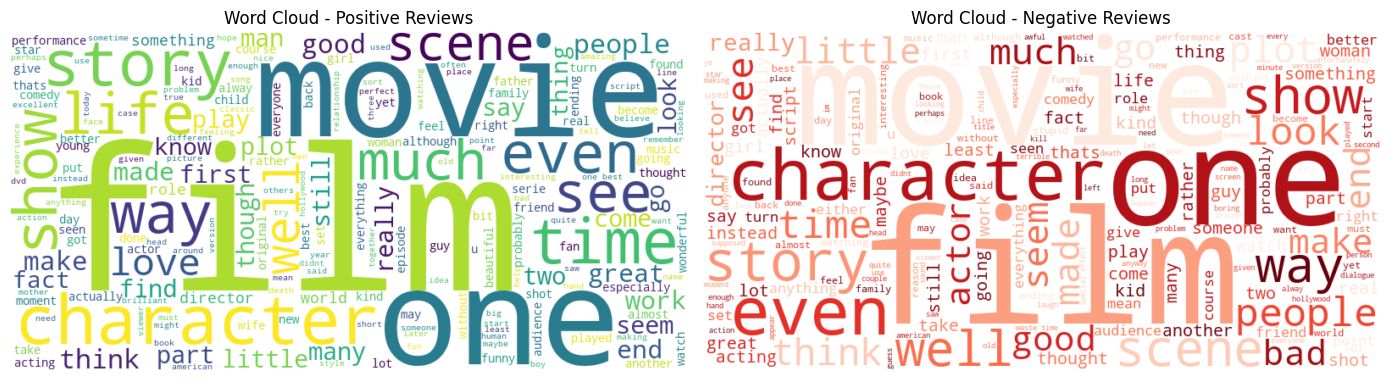

In [30]:
from wordcloud import WordCloud

positive_reviews = ' '.join(df[df['original_sentiment'] == 1]['review'])
negative_reviews = ' '.join(df[df['original_sentiment'] == 0]['review'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(wordcloud_positive, interpolation='bilinear')
ax1.set_title('Word Cloud - Positive Reviews')
ax1.axis('off')

ax2.imshow(wordcloud_negative, interpolation='bilinear')
ax2.set_title('Word Cloud - Negative Reviews')
ax2.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'wordcloud_positive_negative_reviews.png'))
plt.show()

<h3>Feature Vectorization</h3>

In [31]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(df['review'])
X_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
df = pd.concat([df, X_tfidf_df], axis=1)
df.drop(columns=['review'], inplace=True)
df.drop_duplicates(inplace=True)

<h2>Exploratory Data Analysis</h2>
<hr>

<h3>Sentiment Distribution</h3>

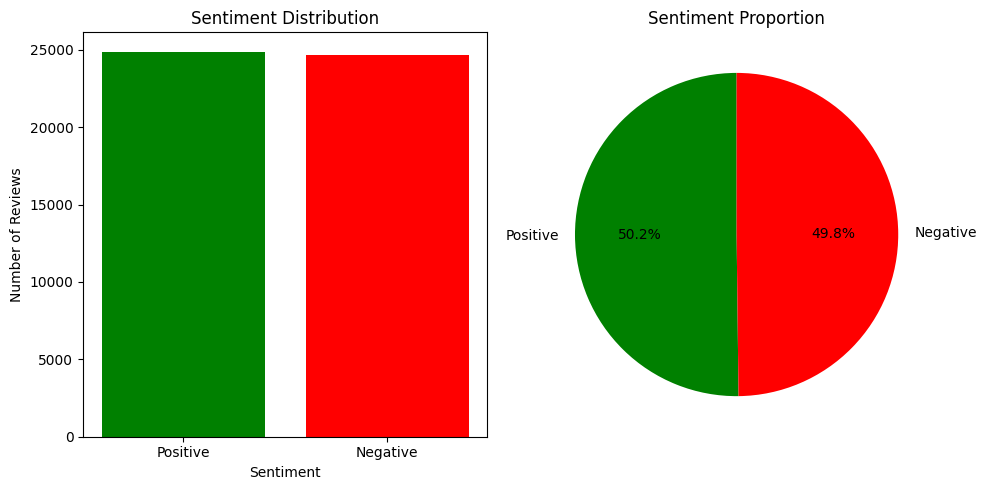

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sentiment_count = df['original_sentiment'].values
positive_count = (sentiment_count == 1).sum()
negative_count = (sentiment_count == 0).sum()

sentiments = ['Positive', 'Negative']
sentiment_counts = [positive_count, negative_count]

ax1.bar(sentiments, sentiment_counts, color=['green', 'red'])
ax1.set_title('Sentiment Distribution')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Reviews')

ax2.pie(sentiment_counts, labels=sentiments, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
ax2.set_title('Sentiment Proportion')

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'sentiment_distribution.png'))
plt.show()

<h3>Review Length Analysis</h3>

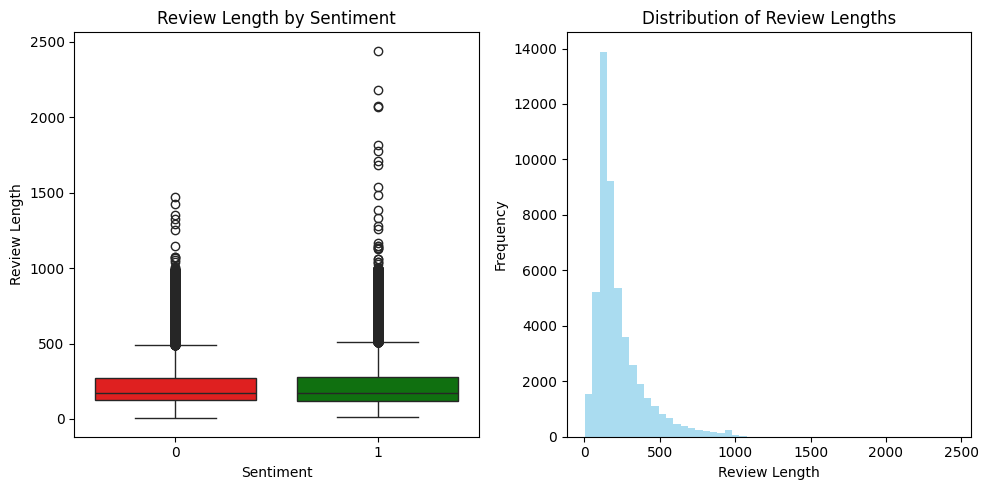

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='original_sentiment', y='review_length', hue='original_sentiment', data=df, palette={0: 'red', 1: 'green'}, ax=ax1, legend=False)
ax1.set_title('Review Length by Sentiment')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Review Length')

ax2.hist(df['review_length'], bins=50, color='skyblue', alpha=0.7)
ax2.set_title('Distribution of Review Lengths')
ax2.set_xlabel('Review Length')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'review_length_analysis.png'))
plt.show()

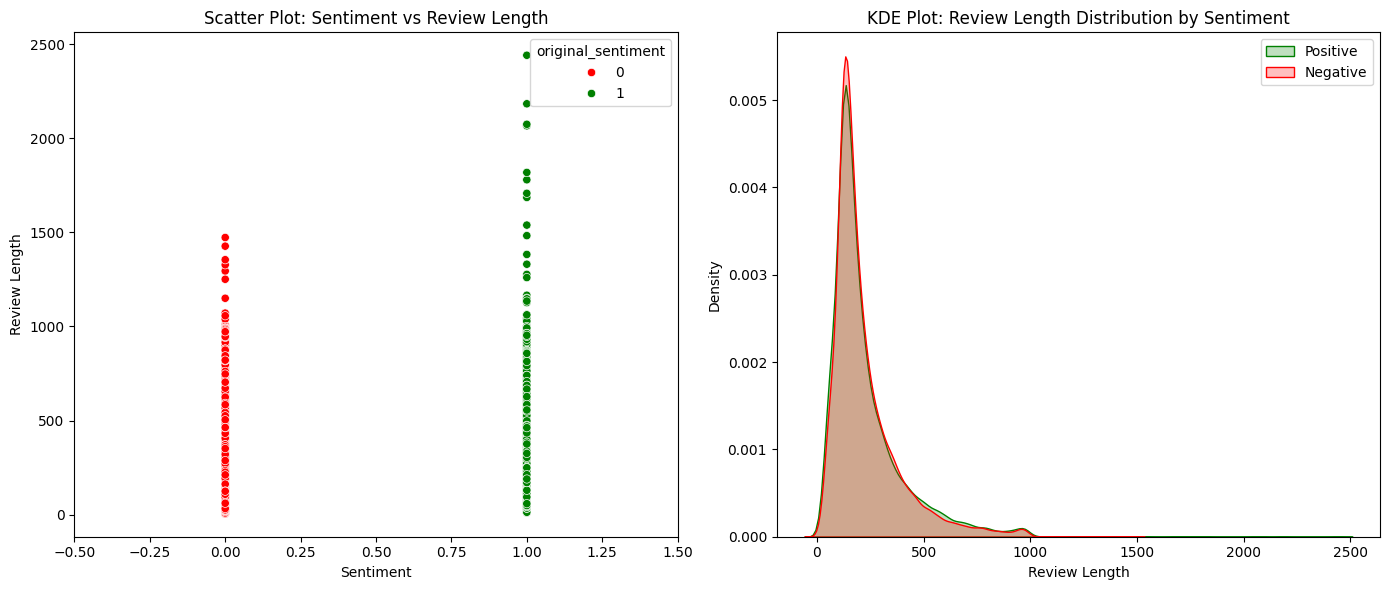

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='original_sentiment', y='review_length', data=df, ax=ax1, palette={0: 'red', 1: 'green'}, hue= "original_sentiment")
ax1.set_xlim(-0.5, 1.5)
ax1.set_title('Scatter Plot: Sentiment vs Review Length')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Review Length')

sns.kdeplot(data=df[df['original_sentiment'] == 1]['review_length'], fill=True, color='green', label='Positive', ax=ax2)
sns.kdeplot(data=df[df['original_sentiment'] == 0]['review_length'], fill=True, color='red', label='Negative', ax=ax2)
ax2.set_title('KDE Plot: Review Length Distribution by Sentiment')
ax2.set_xlabel('Review Length')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'sentiment_vs_review_length_analysis.png'))
plt.show()

<h3>Sentiment Proportion by Review Length</h3>

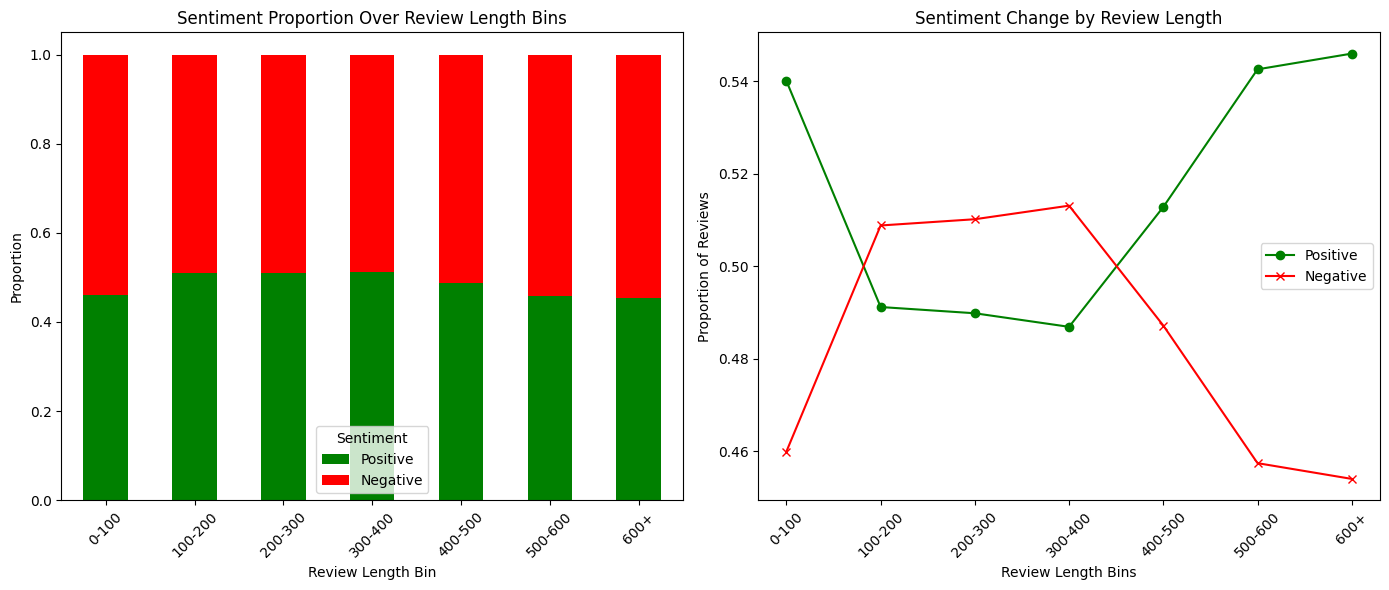

In [35]:
bins = [0, 100, 200, 300, 400, 500, 600, np.inf]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600+']
df['review_length_bin'] = pd.cut(df['review_length'], bins=bins, labels=labels, right=False)

sentiment_proportion = pd.crosstab(df['review_length_bin'], df['original_sentiment'], normalize='index')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sentiment_proportion.plot(kind='bar', stacked=True, color=['green', 'red'], ax=ax1)
ax1.set_title('Sentiment Proportion Over Review Length Bins')
ax1.set_xlabel('Review Length Bin')
ax1.set_ylabel('Proportion')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Sentiment', labels=['Positive', 'Negative'])


ax2.plot(sentiment_proportion.index, sentiment_proportion[1], label='Positive', marker='o', color='green')
ax2.plot(sentiment_proportion.index, sentiment_proportion[0], label='Negative', marker='x', color='red')

ax2.set_title('Sentiment Change by Review Length')
ax2.set_xlabel('Review Length Bins')
ax2.set_ylabel('Proportion of Reviews')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'sentiment_proportion_review_length_bins.png'))
plt.show()

<h3>Identifying Review Length Anomalies</h3>

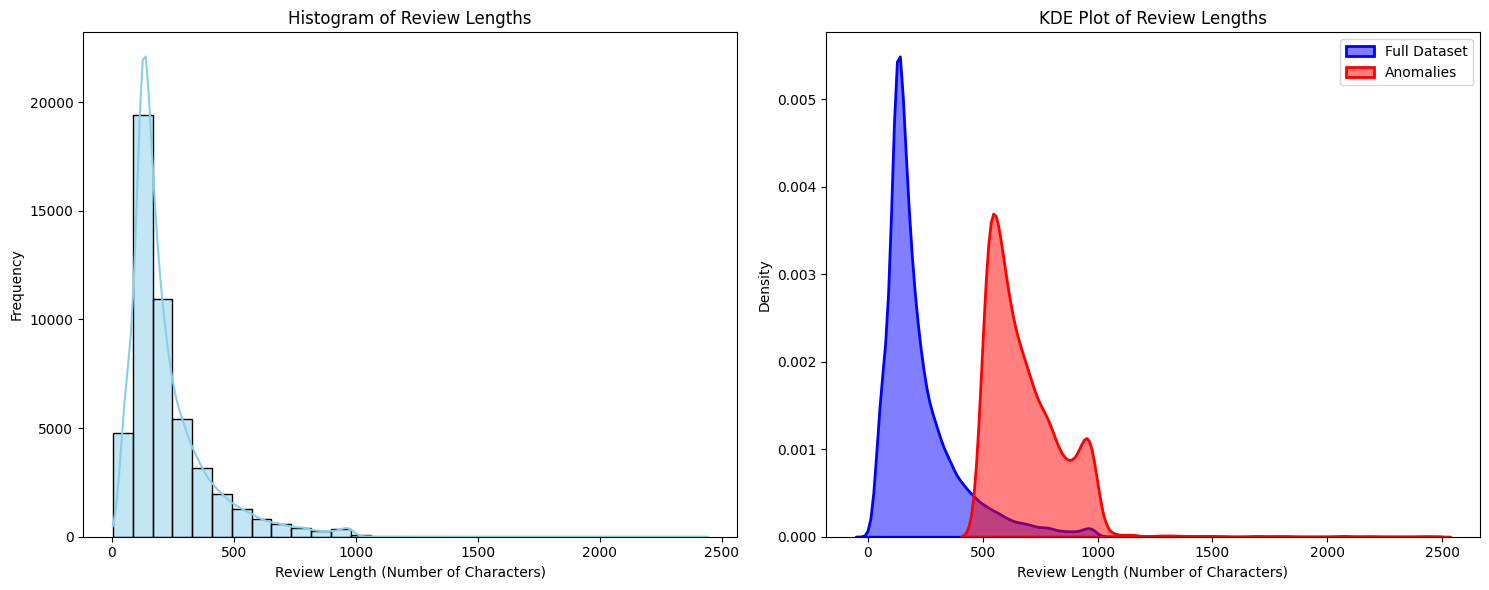

In [36]:
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

anomalies = df[(df['review_length'] < lower_bound) | (df['review_length'] > upper_bound)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['review_length'], kde=True, color='skyblue', bins=30, ax=ax1)
ax1.set_title('Histogram of Review Lengths')
ax1.set_xlabel('Review Length (Number of Characters)')
ax1.set_ylabel('Frequency')

sns.kdeplot(data=df, x="review_length", label="Full Dataset", color="blue", fill=True, alpha=0.5, linewidth=2, ax=ax2)
if not anomalies.empty:
    sns.kdeplot(data=anomalies, x="review_length", label="Anomalies", color="red", fill=True, alpha=0.5, linewidth=2, ax=ax2)
ax2.set_title('KDE Plot of Review Lengths')
ax2.set_xlabel('Review Length (Number of Characters)')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'review_length_anomalies_analysis.png'))
plt.show()

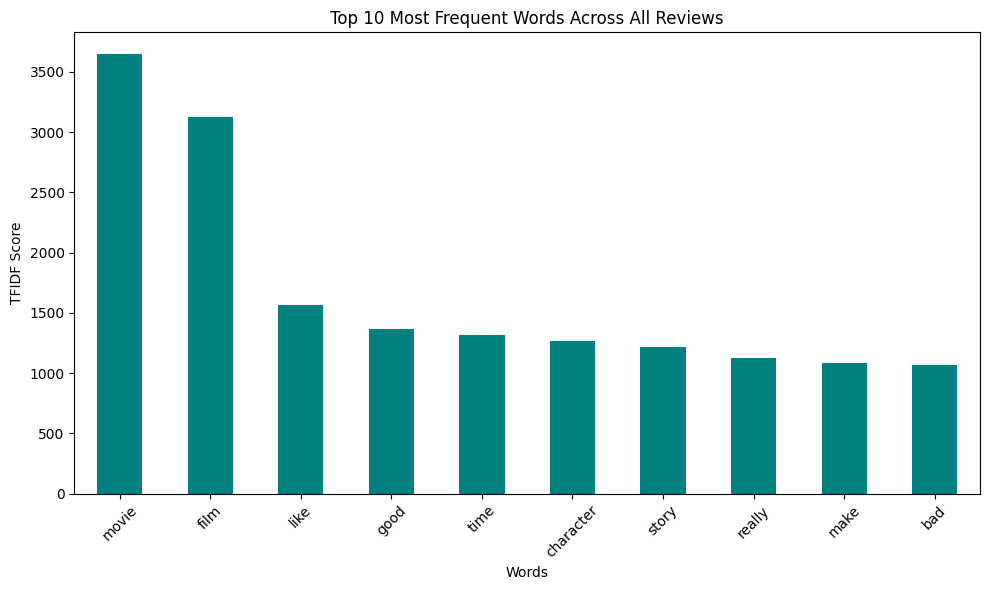

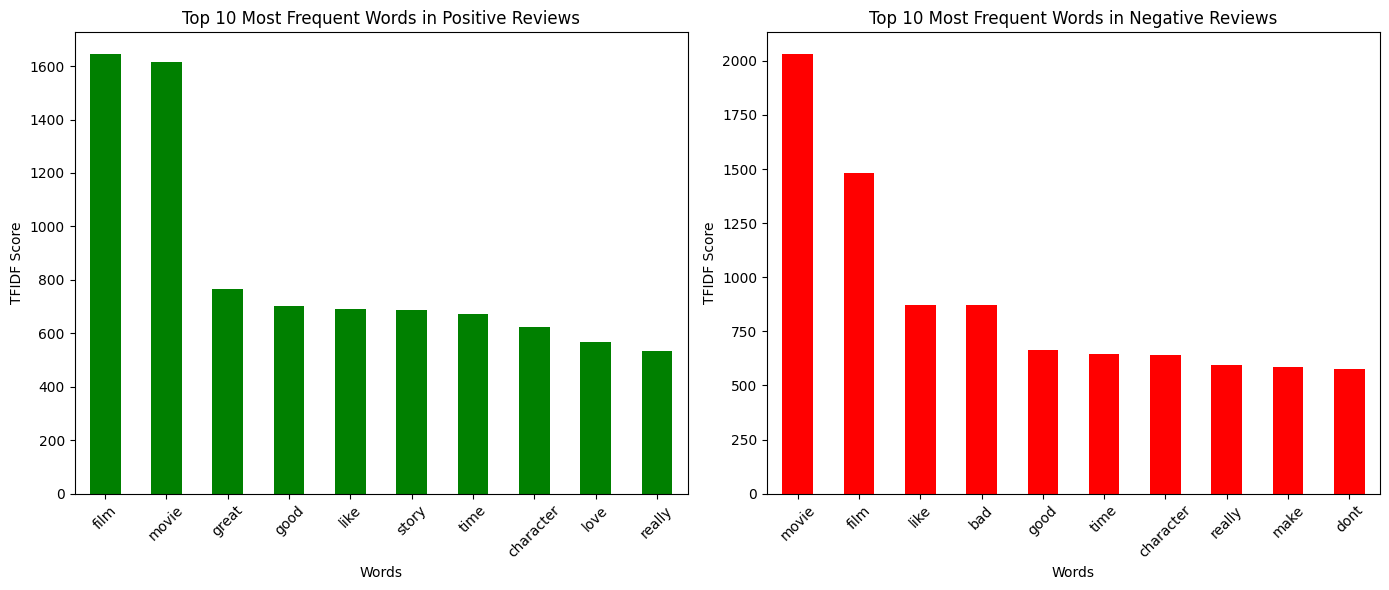

In [37]:
tfidf_df = df.copy()
tfidf_df.drop(['original_sentiment', 'review_length', 'review_length_bin'], axis=1, inplace=True)
all_matrix = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)

# Plotting the top 10 most important features (based on TFIDF scores)
plt.figure(figsize=(10, 6))
all_matrix.plot(kind='bar', color='teal')
plt.title('Top 10 Most Frequent Words Across All Reviews')
plt.xlabel('Words')
plt.ylabel('TFIDF Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'top_10_most_frequent_words.png'))
plt.show()

positive_reviews = df[df['original_sentiment'] == 1][tfidf_df.columns]
negative_reviews = df[df['original_sentiment'] == 0][tfidf_df.columns]
top_words_positive = positive_reviews.sum(axis=0).sort_values(ascending=False).head(10)
top_words_negative = negative_reviews.sum(axis=0).sort_values(ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

top_words_positive.plot(kind='bar', color='green', ax=ax1)
ax1.set_title('Top 10 Most Frequent Words in Positive Reviews')
ax1.set_xlabel('Words')
ax1.set_ylabel('TFIDF Score')
ax1.tick_params(axis='x', rotation=45)

top_words_negative.plot(kind='bar', color='red', ax=ax2)
ax2.set_title('Top 10 Most Frequent Words in Negative Reviews')
ax2.set_xlabel('Words')
ax2.set_ylabel('TFIDF Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'top_words_in_positive_and_negative_reviews.png'))
plt.show()

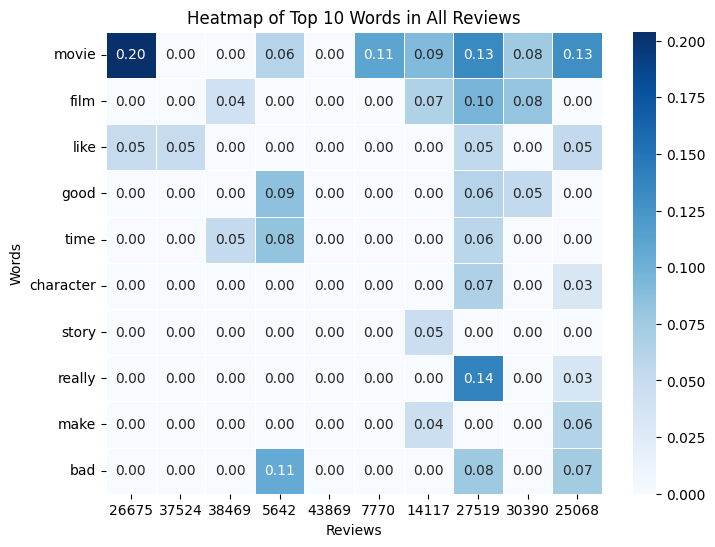

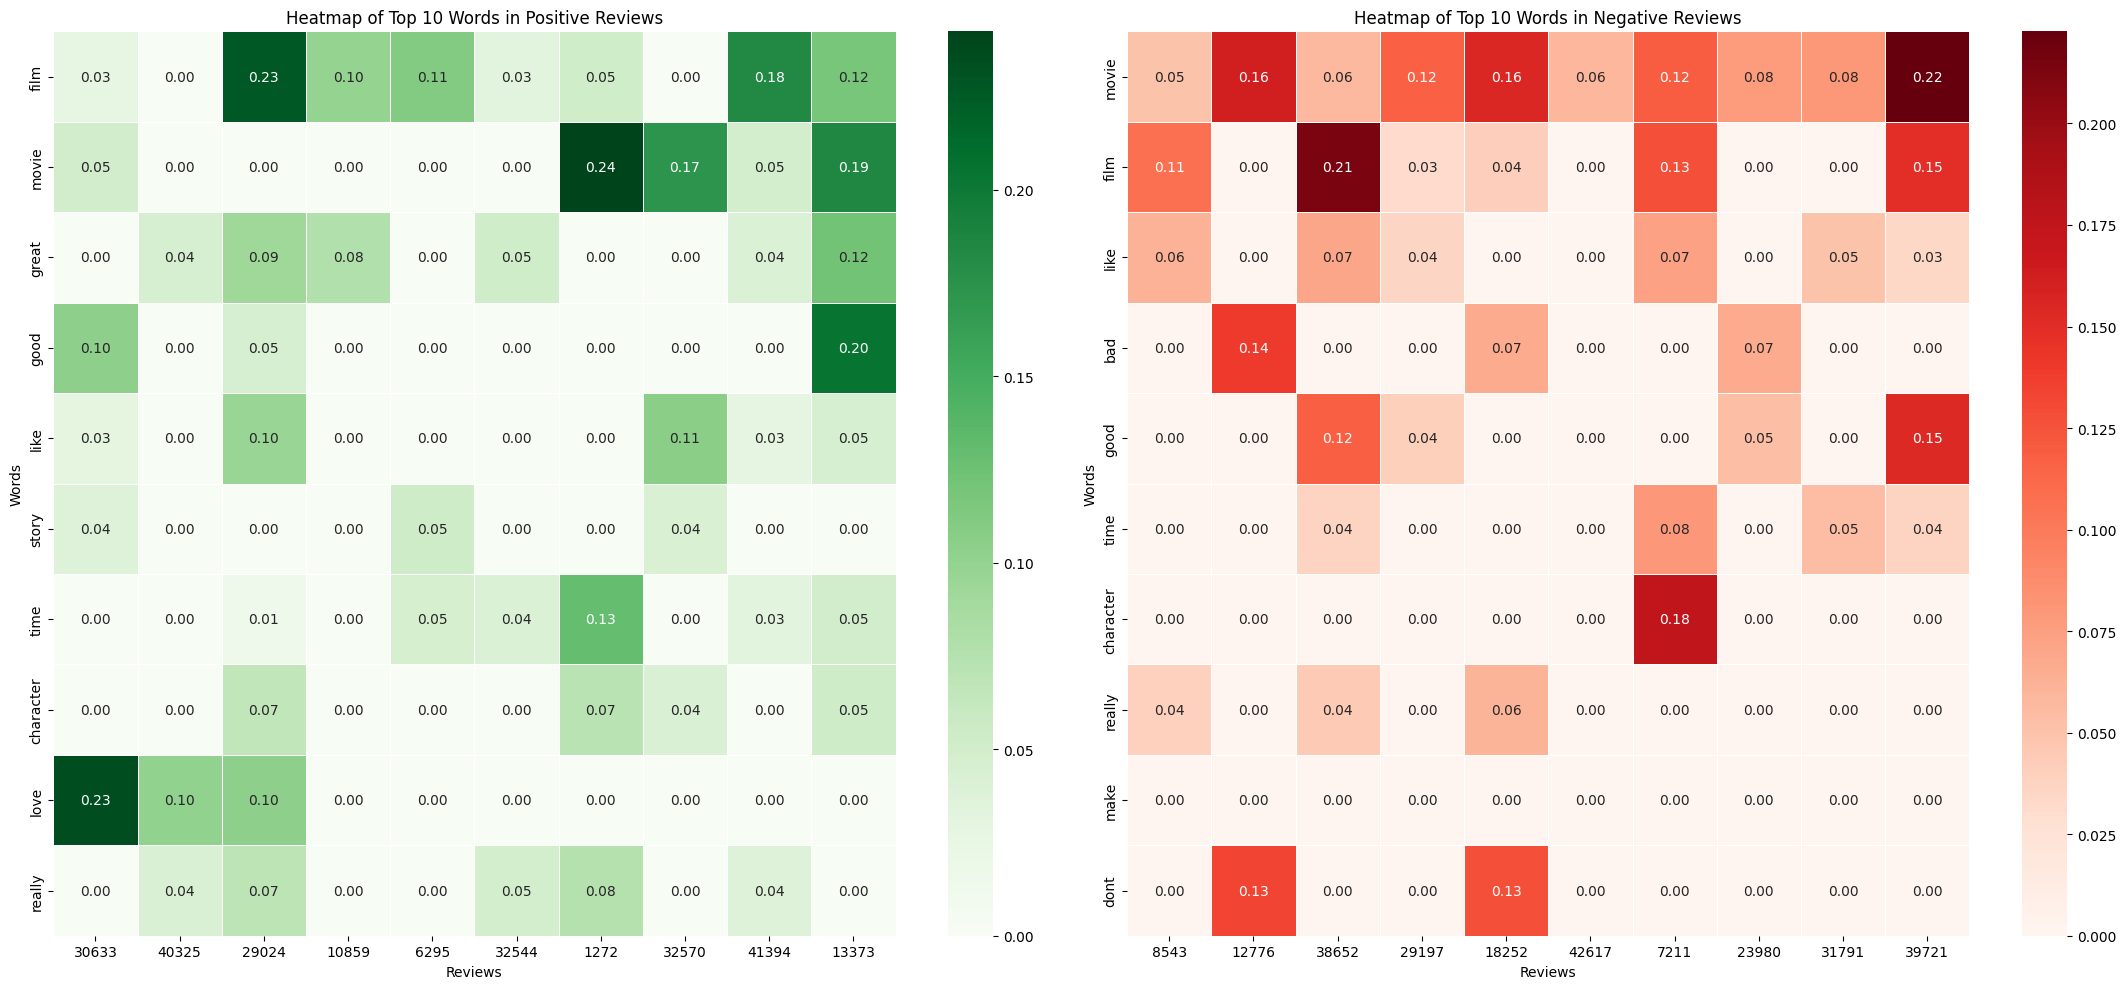

In [38]:
sampled_reviews = tfidf_df[all_matrix.index].T.sample(n=10, axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(sampled_reviews, cmap="Blues", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Top 10 Words in All Reviews")
plt.xlabel("Reviews")
plt.ylabel("Words")
plt.savefig(os.path.join(eda_folder, 'heatmap_top_10_words_sampled_reviews.png'))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sampled_positive_reviews = positive_reviews[top_words_positive.index].T.sample(n=10, axis=1)
sns.heatmap(sampled_positive_reviews, cmap="Greens", annot=True, fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Heatmap of Top 10 Words in Positive Reviews")
axes[0].set_xlabel("Reviews")
axes[0].set_ylabel("Words")

sampled_negative_reviews = negative_reviews[top_words_negative.index].T.sample(n=10, axis=1)
sns.heatmap(sampled_negative_reviews, cmap="Reds", annot=True, fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Heatmap of Top 10 Words in Negative Reviews")
axes[1].set_xlabel("Reviews")
axes[1].set_ylabel("Words")

plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'heatmap_top_words_positive_and_negative_reviews.png'))
plt.show()

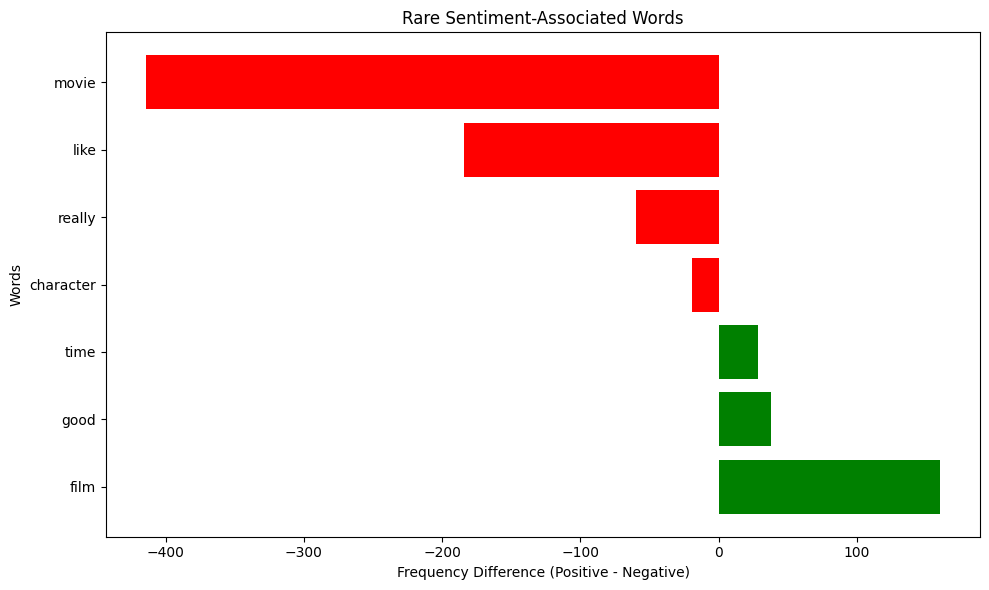

In [39]:
word_diff = top_words_positive - top_words_negative

sentiment_specific_words = word_diff.sort_values(ascending=False)

rare_positive_words = sentiment_specific_words[sentiment_specific_words > 0].head(20)
rare_negative_words = sentiment_specific_words[sentiment_specific_words < 0].head(20)

rare_words = pd.concat([rare_positive_words, rare_negative_words])

plt.figure(figsize=(10, 6))
plt.barh(rare_words.index, rare_words.values, color=['green' if x > 0 else 'red' for x in rare_words.values])
plt.title('Rare Sentiment-Associated Words')
plt.xlabel('Frequency Difference (Positive - Negative)')
plt.ylabel('Words')
plt.tight_layout()
plt.savefig(os.path.join(eda_folder, 'rare_sentiment_associated_words.png'))
plt.show()

In [40]:
df.head(10)

original_sentiment  review_length  abandoned  ability  able  absolute  \
0                   1            300          0        0     0         0   
1                   1            156          0        0     0         0   
2                   1            161          0        0     0         0   
3                   0            128          0        0     0         0   
4                   1            222          0        0     0         0   
5                   1            117          0        0     0         0   
6                   1            149          0        0     0         0   
7                   0            166          0        0     0         0   
8                   0            123          0        0     0         0   
9                   1             31          0        0     0         0   

   absolutely  absurd  abuse  academy  accent  accept  acceptable  accepted  \
0           0       0      0        0       0       0           0         0   
1           0       0      0        0       0       0           0         0   
2           0       0      0        0       0       0           0         0   
3           0       0      0        0       0       0           0         0   
4           0       0      0        0       0       0           0         0   
5           0       0      0        0       0       0           0         0   
6           0       0      0        0       0       0           0         0   
7           0       0      0        0       0       0           0         0   
8           0       0      0        0       0       0           0         0   
9           0       0      0        0       0       0           0         0   

   accident  accidentally  according  account  accurate  accused  achieve  \
0         0             0          0        0         0        0        0   
1         0             0          0        0         0        0        0   
2         0             0          0        0         0        0        0   
3         0             0          0        0         0        0        0   
4         0             0          0        0         0        0        0   
5         0             0          0        0         0        0        0   
6         0             0          0        0         0        0        0   
7         0             0          0        0         0        0        0   
8         0             0          0        0         0        0        0   
9         0             0          0        0         0        0        0   

   achieved  achievement  act  acted    acting    action  activity     actor  \
0         0            0    0      0         0         0         0         0   
1         0            0    0      0         0         0         0  0.072005   
2         0            0    0      0         0         0         0         0   
3         0            0    0      0         0         0         0         0   
4         0            0    0      0  0.059279  0.078038         0         0   
5         0            0    0      0         0         0         0         0   
6         0            0    0      0         0         0         0         0   
7         0            0    0      0         0         0         0         0   
8         0            0    0      0  0.093134         0         0         0   
9         0            0    0      0         0         0         0         0   

   actress  actual  actually  ad  adam  adaptation  adapted  add  added  \
0        0       0         0   0     0           0        0    0      0   
1        0       0         0   0     0           0        0    0      0   
2        0       0         0   0     0           0        0    0      0   
3        0       0         0   0     0           0        0    0      0   
4        0       0         0   0     0           0        0    0      0   
5        0       0         0   0     0           0        0    0      0   
6        0       0         0   0     0    

<h4>Scaling Review Length</h4>

In [41]:
scaler = MinMaxScaler()
df['review_length'] = scaler.fit_transform(df[['review_length']])
df = df.drop('review_length_bin', axis=1)

In [42]:
df.to_csv('IMDB Dataset preprocessed.csv', index=False)

<h2>Sentiment Analysis</h2>

***This section includes the steps for sentiment analysis, classification models, and clustering.***
<hr>

<h3>Import Libraries and Load Data</h3>

In [43]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, silhouette_score

In [44]:
df = pd.read_csv('IMDB Dataset preprocessed.csv')

In [45]:
y = df['original_sentiment']
X = df.drop('original_sentiment', axis=1)

<h4>Splitting The Dataset</h4>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>K-Means Cluster</h3>

In [47]:
kmeans_folder = os.path.join(main_plots_folder, "KMeans_plots")
os.makedirs(kmeans_folder, exist_ok=True)

<h4>Finding Optimal K</h4>

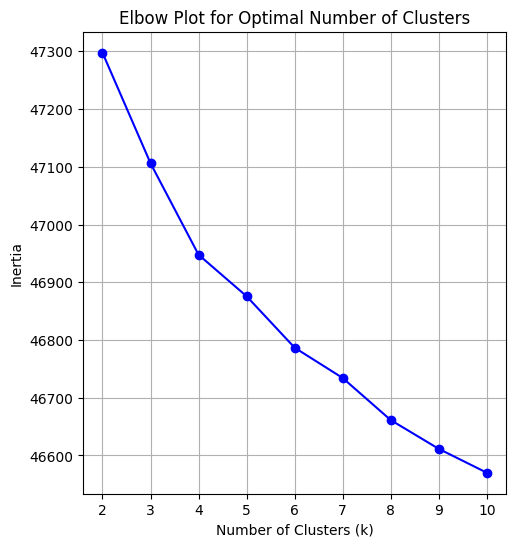

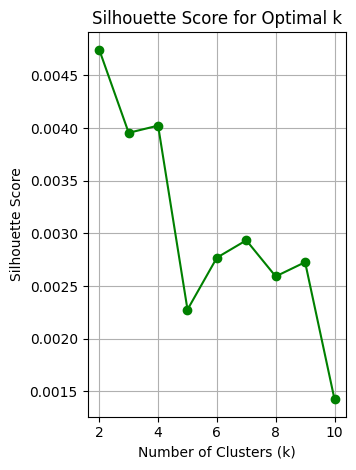

In [48]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k,n_init='auto', random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

    if k > 1:
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(None)

inertia_diffs = np.diff(inertias)
best_k_elbow = k_range[np.argmax(inertia_diffs) + 1]

# Plot Elbow curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o', color='b')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

best_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]

# Plot sihouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='g')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(kmeans_folder, 'optimal_clusters_plots.png'))
plt.show()

In [49]:
print(f"Optimal k based on Elbow method: {best_k_elbow}")
print(f"Optimal k based on Silhouette Score: {best_k_silhouette}")
print("Since there are only 2 sentiment categories, it makes the most sense to choose k =", best_k_silhouette)

Optimal k based on Elbow method: 10
Optimal k based on Silhouette Score: 2
Since there are only 2 sentiment categories, it makes the most sense to choose k = 2


<h4>Running K-Means Clustering</h4>

In [50]:
start_time = time.time()
k = best_k_silhouette
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_train)
train_clusters = kmeans.predict(X_train)
test_clusters = kmeans.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time

<h4>Performance Metrics</h4>

In [51]:
train_accuracy = accuracy_score(y_train, train_clusters)
test_accuracy = accuracy_score(y_test, test_clusters)

# Performance Metrics
print(f"Execution Time: {execution_time:.4f} seconds")
print(f"Memory Usage: {X.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Final Inertia: {kmeans.inertia_:.2f}")

Execution Time: 20.2319 seconds
Memory Usage: 1134.68 MB
Train Accuracy: 0.5651790216843167
Test Accuracy: 0.5653050932929904
Final Inertia: 37838.40


In [52]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

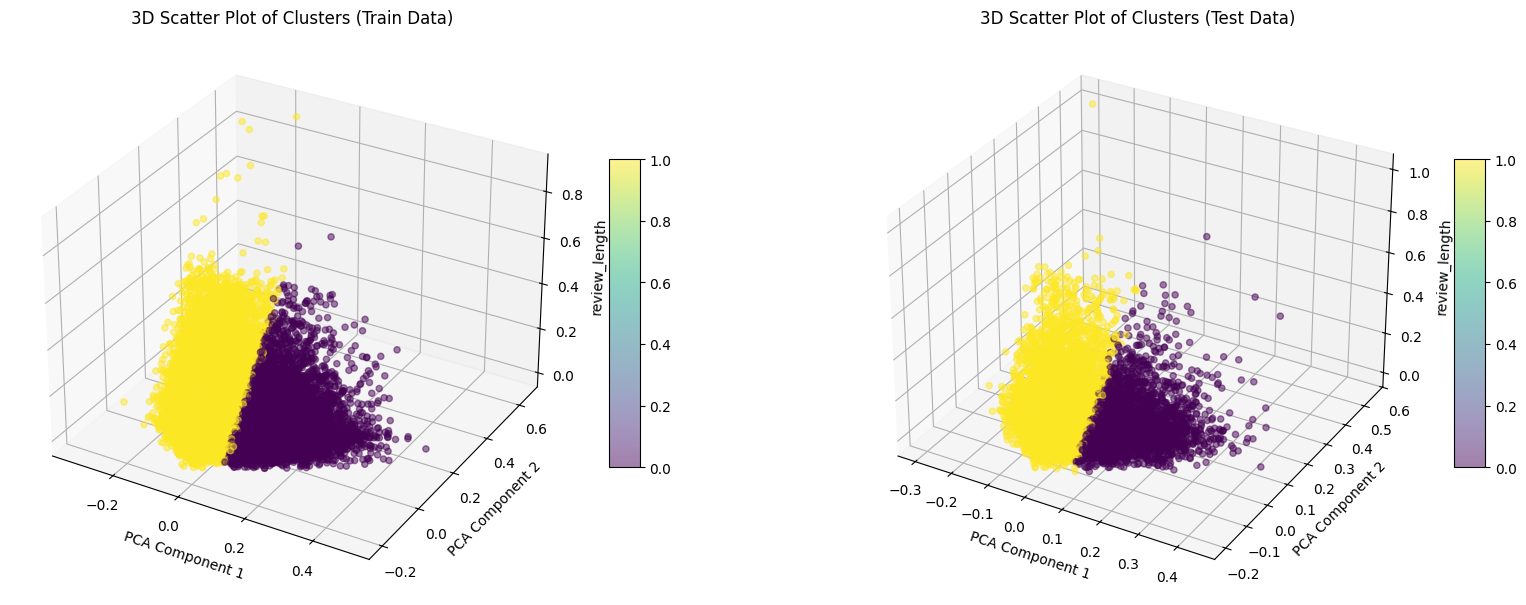

In [53]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'})

sc1 = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train['review_length'], c=train_clusters, cmap='viridis', alpha=0.5)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('review_length')
fig.colorbar(sc1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title('3D Scatter Plot of Clusters (Train Data)')

sc2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test['review_length'], c=test_clusters, cmap='viridis', alpha=0.5)
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('review_length')
fig.colorbar(sc2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title('3D Scatter Plot of Clusters (Test Data)')

plt.savefig(os.path.join(kmeans_folder, '3d_scatter_plot_clusters.png'))
plt.show()

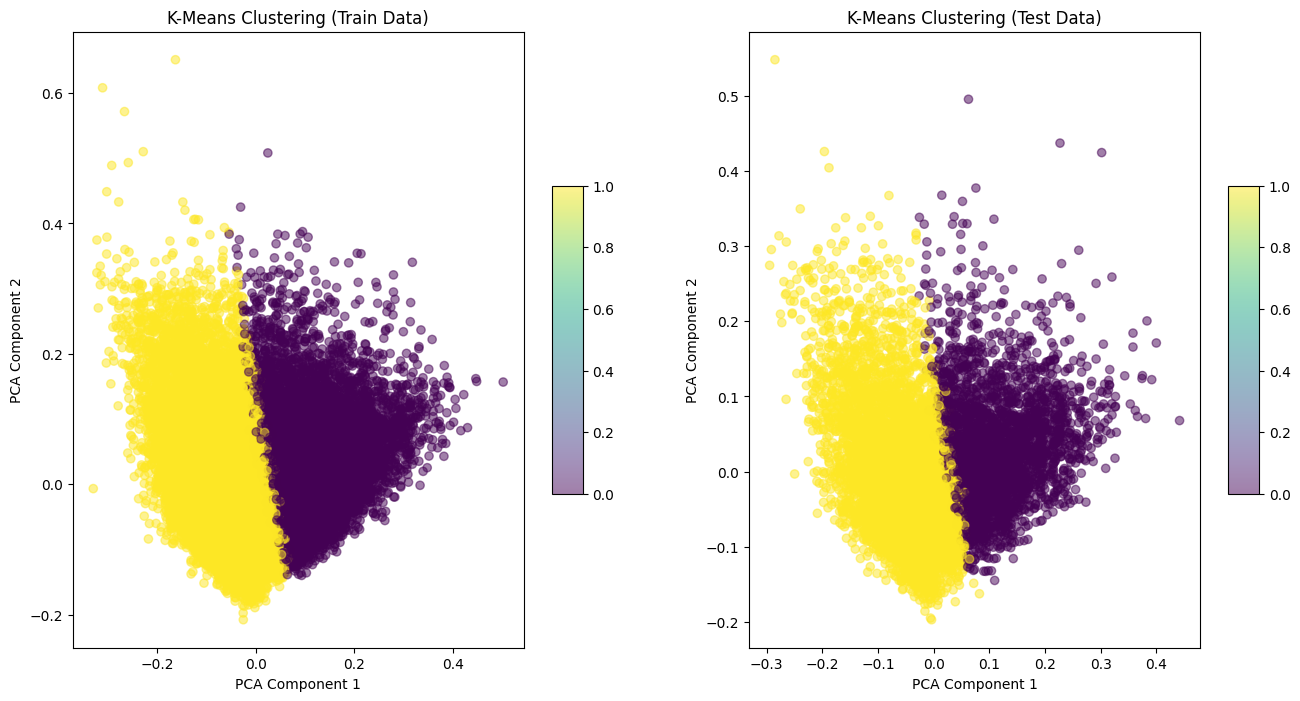

In [54]:
# 2D Scatter Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sc1 = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', alpha=0.5)
ax1.set_title("K-Means Clustering (Train Data)")
ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
fig.colorbar(sc1, ax=ax1, shrink=0.5, aspect=10)

sc2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters, cmap='viridis', alpha=0.5)
ax2.set_title("K-Means Clustering (Test Data)")
ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
fig.colorbar(sc2, ax=ax2, shrink=0.5, aspect=10)

plt.savefig(os.path.join(kmeans_folder, '2d_scatter_plot_clusters.png'))
plt.show()

In [55]:
train_df = X_train.copy()
train_df['cluster'] = train_clusters

print("\nTrain Cluster Sizes:")
print(train_df.groupby('cluster').size())

print("\nTrain Cluster Insights:")
for cluster in train_df['cluster'].unique():
    cluster_data = train_df[train_df['cluster'] == cluster]
    print(f"\nCluster {cluster} characteristics (Train Data):")
    print(cluster_data.describe())


Train Cluster Sizes:
cluster
0    12679
1    26981
dtype: int64

Train Cluster Insights:

Cluster 1 characteristics (Train Data):
       review_length     abandoned       ability          able      absolute  \
count   26981.000000  26981.000000  26981.000000  26981.000000  26981.000000   
mean        0.098338      0.000895      0.002487      0.004333      0.001617   
std         0.074368      0.011029      0.017639      0.021600      0.015197   
min         0.001641      0.000000      0.000000      0.000000      0.000000   
25%         0.050451      0.000000      0.000000      0.000000      0.000000   
50%         0.073011      0.000000      0.000000      0.000000      0.000000   
75%         0.121821      0.000000      0.000000      0.000000      0.000000   
max         0.894176      0.323132      0.332309      0.382996      0.331755   

         absolutely        absurd         abuse       academy        accent  \
count  26981.000000  26981.000000  26981.000000  26981.000000  26981.

In [56]:
test_df = X_test.copy()
test_df['cluster'] = test_clusters

print("\nTest Cluster Sizes:")
print(test_df.groupby('cluster').size())

print("\nTest Cluster Insights:")
for cluster in test_df['cluster'].unique():
    cluster_data = test_df[test_df['cluster'] == cluster]
    print(f"\nCluster {cluster} characteristics (Test Data):")
    print(cluster_data.describe())


Test Cluster Sizes:
cluster
0    3201
1    6714
dtype: int64

Test Cluster Insights:

Cluster 0 characteristics (Test Data):
       review_length    abandoned      ability         able     absolute  \
count    3201.000000  3201.000000  3201.000000  3201.000000  3201.000000   
mean        0.074527     0.000509     0.001416     0.004029     0.001519   
std         0.051157     0.008432     0.014337     0.022630     0.016012   
min         0.005742     0.000000     0.000000     0.000000     0.000000   
25%         0.046349     0.000000     0.000000     0.000000     0.000000   
50%         0.059475     0.000000     0.000000     0.000000     0.000000   
75%         0.087367     0.000000     0.000000     0.000000     0.000000   
max         0.554143     0.218598     0.291821     0.356611     0.297710   

        absolutely       absurd        abuse      academy       accent  \
count  3201.000000  3201.000000  3201.000000  3201.000000  3201.000000   
mean      0.007048     0.001119     0.000

<h3>Logistic Regression</h3>

In [57]:
logit_folder = os.path.join(main_plots_folder, "Logit_plots")
os.makedirs(logit_folder, exist_ok=True)

<h4>Training the Model</h4>

In [58]:
start_time = time.time()

LogitModel = LogisticRegression(penalty='l2', C=1, random_state=42, verbose=1)
LogitModel.fit(X_train, y_train)
print(LogitModel.n_iter_)

end_time = time.time()
execution_time = end_time - start_time

[17]


In [59]:
y_pred = LogitModel.predict(X_test)

<h4>Model Evaluation: Accuracy, Confusion Matrix, ROC Curve, and Precision-Recall Curve</h4>

Optimal Threshold: 0.4765339353095638
Execution Time: 3.5236 seconds
Accuracy: 0.886737266767524
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4881
           1       0.87      0.91      0.89      5034

    accuracy                           0.89      9915
   macro avg       0.89      0.89      0.89      9915
weighted avg       0.89      0.89      0.89      9915



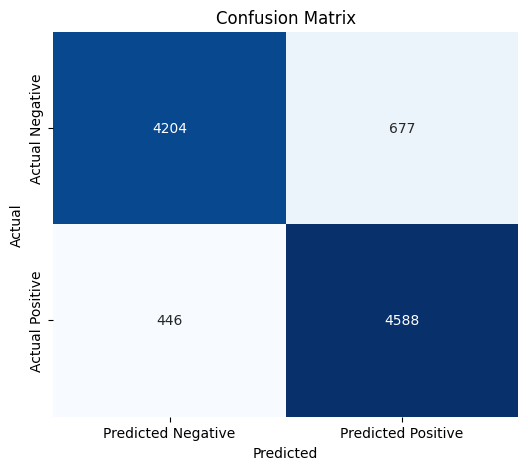

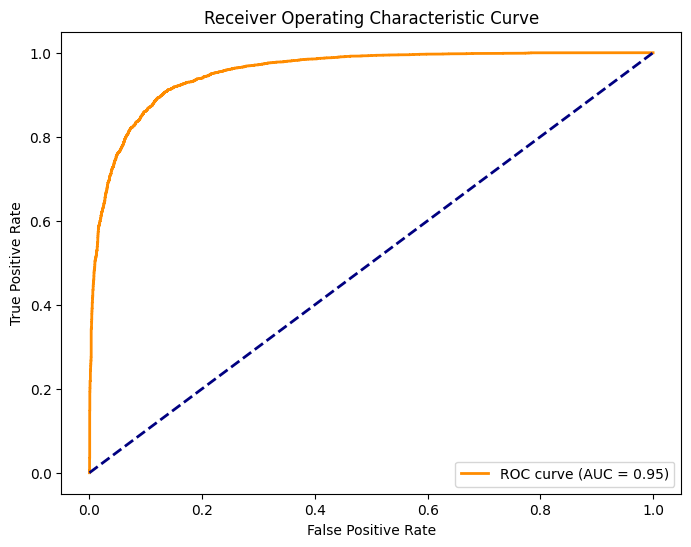

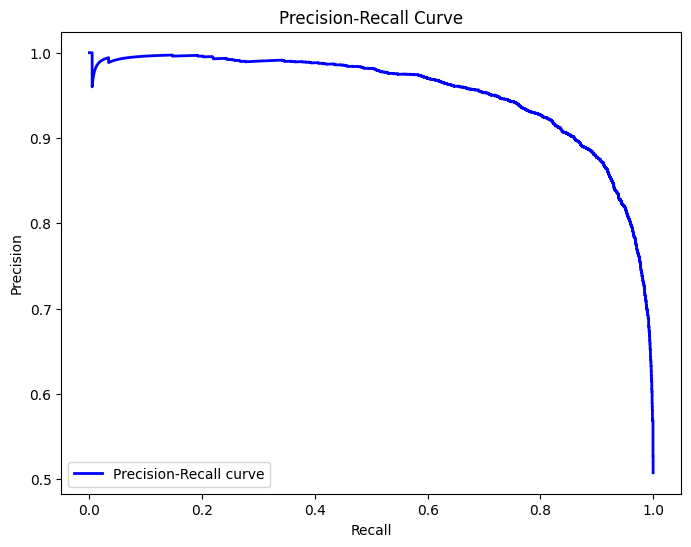

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, LogitModel.predict_proba(X_test)[:, 1])
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)
y_scores = LogitModel.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)

# Model Evaluation
print(f"Execution Time: {execution_time:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))

cm = confusion_matrix(y_test, y_pred_adjusted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(logit_folder, 'confusion_matrix.png'))
plt.show()

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(logit_folder, 'roc_curve.png'))
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, LogitModel.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(os.path.join(logit_folder, 'precision_recall_curve.png'))
plt.show()

<h3>Naive Bayes Classifier</h3>

<h4>Training the Naive Bayes Model</h4>

In [61]:
NB_folder = os.path.join(main_plots_folder, "NB_plots")
os.makedirs(NB_folder, exist_ok=True)

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 0.2, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'alpha': 2.0, 'fit_prior': True}


In [63]:
start_time = time.time()
NBModel = MultinomialNB(alpha= 2.0, fit_prior= False)
NBModel.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time

In [64]:
y_pred = NBModel.predict(X_test)

<h4>Model Evaluation: Accuracy, Confusion Matrix, ROC Curve, and Precision-Recall Curve</h4>

Execution Time: 0.1708 seconds
Accuracy: 0.8529500756429652
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4881
           1       0.85      0.87      0.86      5034

    accuracy                           0.85      9915
   macro avg       0.85      0.85      0.85      9915
weighted avg       0.85      0.85      0.85      9915



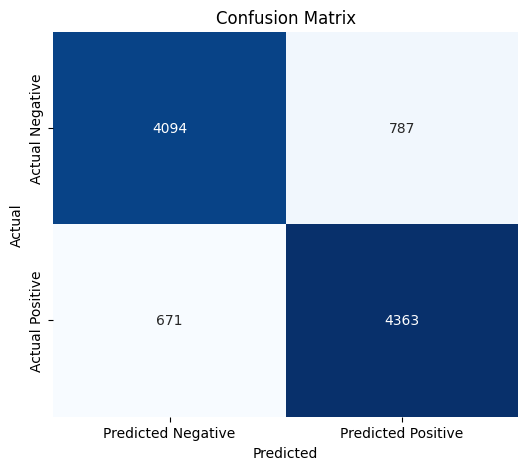

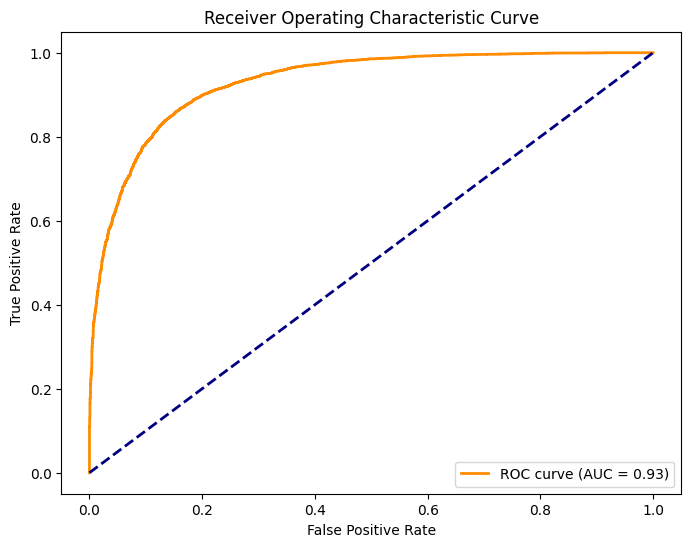

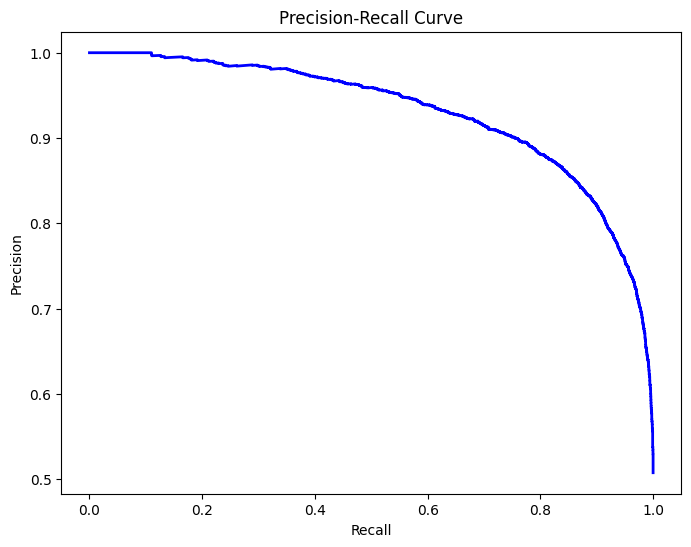

In [65]:
# Model Evaluation
print(f"Execution Time: {execution_time:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(NB_folder, 'confusion_matrix.png'))
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, NBModel.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(NB_folder, 'roc_curve.png'))
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, NBModel.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig(os.path.join(NB_folder, 'precision_recall_curve.png'))
plt.show()

<h3>Decision Tree Classifier</h3>

<h4>Training the Decision Tree Model</h4>

In [66]:
DT_folder = os.path.join(main_plots_folder, "DT_plots")
os.makedirs(DT_folder, exist_ok=True)

In [67]:
start_time = time.time()
DTModel = DecisionTreeClassifier(max_depth=24, min_samples_leaf=2, min_samples_split=5, random_state=42)
DTModel.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time

In [68]:
y_pred = DTModel.predict(X_test)

<h4>Model Evaluation: Accuracy, Confusion Matrix, ROC Curve, Precision-Recall Curve, Feature Importance</h4>

Execution Time: 13.2134 seconds
Accuracy: 0.7503
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.66      0.72      4881
           1       0.72      0.84      0.77      5034

    accuracy                           0.75      9915
   macro avg       0.76      0.75      0.75      9915
weighted avg       0.76      0.75      0.75      9915



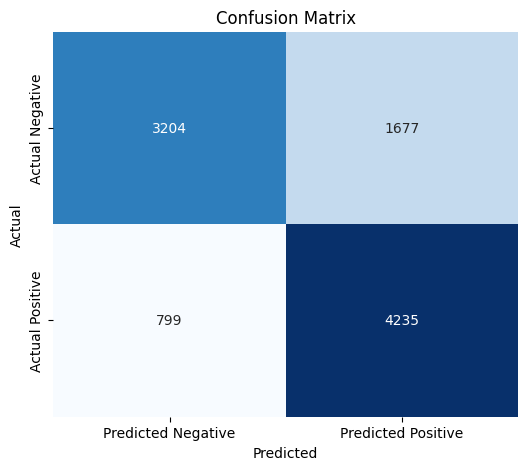

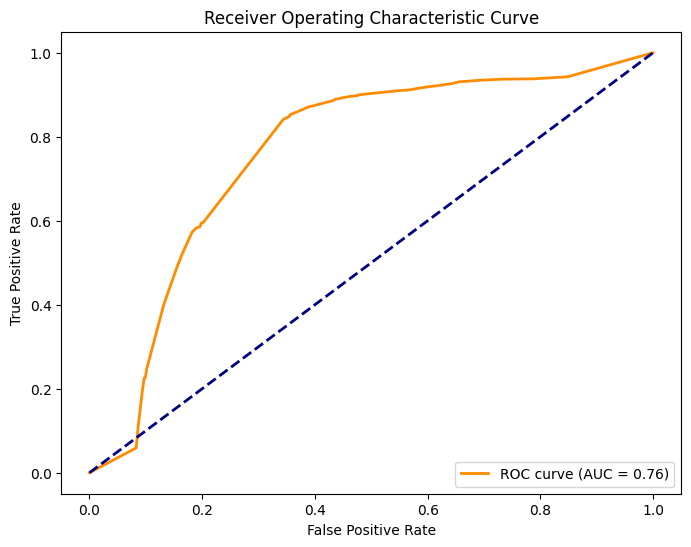

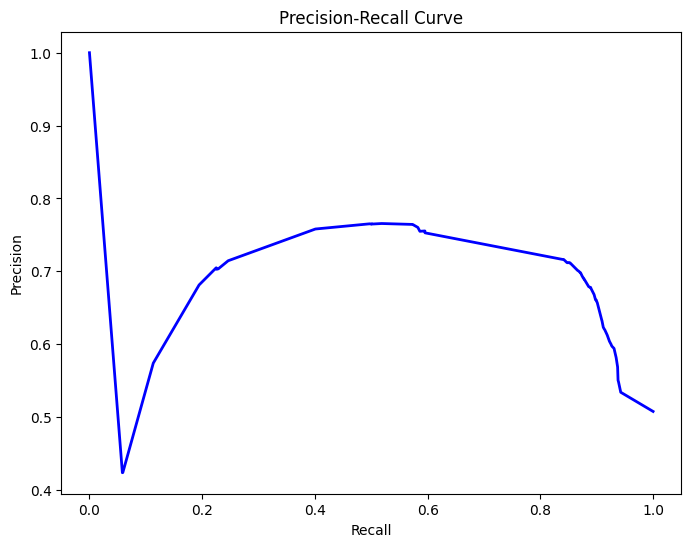

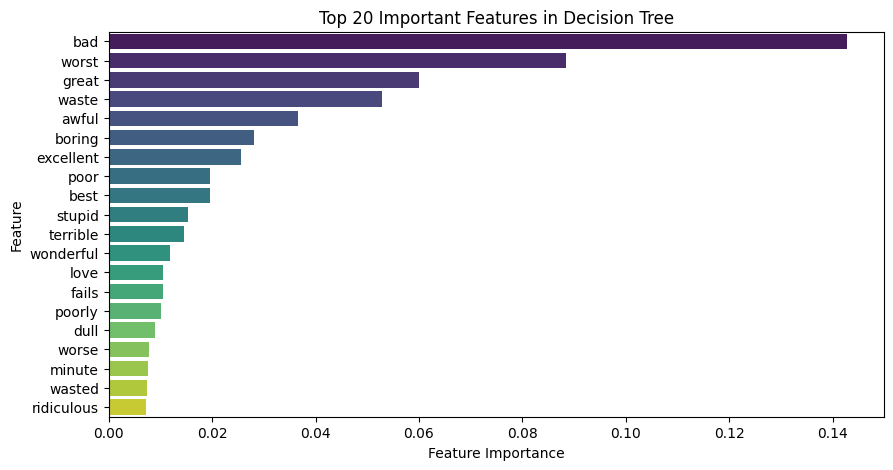

In [69]:
# Model Evaluation
print(f"Execution Time: {execution_time:.4f} seconds")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(DT_folder, 'confusion_matrix.png'))
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, DTModel.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(DT_folder, 'roc_curve.png'))
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, DTModel.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig(os.path.join(DT_folder, 'precision_recall_curve.png'))
plt.show()

feature_importance = DTModel.feature_importances_
features = X_train.columns

# Convert to DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': DTModel.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='viridis', legend=False)
plt.title('Top 20 Important Features in Decision Tree')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.savefig(os.path.join(DT_folder, 'feature_importance.png'))
plt.show()